In [1]:
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LinearRegression
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


In [2]:
# load data

xtrain = np.load("X_train_regression1.npy")
ytrain = np.load("y_train_regression1.npy")

xtest = np.load("X_test_regression1.npy")

# Chosen Model: Lasso 

Code to get the predictions:

In [3]:
# final predictions and file 

final_model = Lasso(alpha=0.08406652885618317,fit_intercept=True)
final_model.fit(xtrain, ytrain)
ypred = final_model.predict(xtest)
print(ypred.shape)
np.save('y_test.npy', ypred)

(1000,)


The work behind understanding which model works the best is below, first for the chosen model and then for other models tested.

## Understanding the data

In [4]:
print(xtrain.shape)
print(ytrain.shape)

(15, 10)
(15, 1)


In [5]:
# training set is very small, using normal regression will most likely lead to overfit. regularization methods will most likely perform better since
# generalize the model

In [6]:
# x train variance

xtrain_var = np.var(xtrain, axis = 1)
print(np.mean(xtrain_var))

# x test variance

xtest_var = np.var(xtest, axis = 1)
print(np.mean(xtest_var))

# x train std

xtrain_std = np.std(xtrain, axis = 1)
print(np.mean(xtrain_std))

# x test std

xtest_std = np.std(xtest, axis = 1)
print(np.mean(xtest_std))


0.8035506195830407
0.9139466852189216
0.8720130450976477
0.9309266386589962


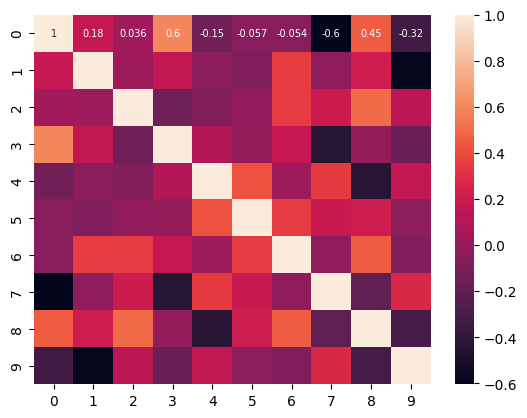

In [7]:
# heatmap of correlation matrix

corr = np.corrcoef(xtrain, rowvar = False)
sns.heatmap(corr, annot = True, annot_kws={"size": 7})
plt.show()


## Lasso

Using GridSearchCV and other packages

In [8]:

n_alphas = 200
alphas = np.logspace(-10, 2, n_alphas)

param_grid = {"alpha": alphas}
lassomodel = Lasso(fit_intercept=True)

searchlasso = GridSearchCV(estimator=lassomodel, param_grid=param_grid, n_jobs=2, scoring='neg_mean_squared_error', cv=LeaveOneOut())
searchlasso.fit(xtrain, ytrain)

print(f"The best parameters found is: {searchlasso.best_params_}")

best_alpha_lasso = searchlasso.best_params_['alpha']

The best parameters found is: {'alpha': 0.08406652885618317}


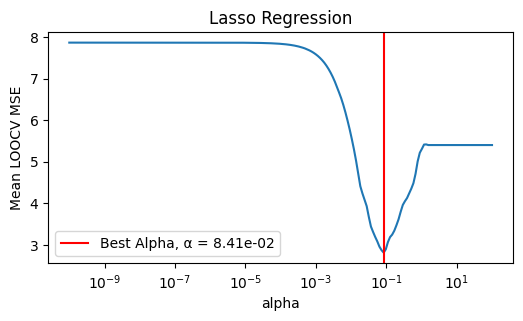

In [9]:
searchlasso.cv_results_.keys()

test_scoreslasso = np.zeros((len(searchlasso.cv_results_['params']), searchlasso.n_splits_))
for i, params in enumerate(searchlasso.cv_results_['params']):
    for j in range(searchlasso.n_splits_):
        test_scoreslasso[i, j] = searchlasso.cv_results_[f'split{j}_test_score'][i]

# plot test scores

plt.figure(figsize=(6, 3))
plt.semilogx(alphas, -test_scoreslasso.mean(axis=1))
plt.xlabel('alpha')
plt.axvline(x = best_alpha_lasso, color = 'r', label = 'Best Alpha, \u03B1 = {:.2e}'.format(best_alpha_lasso))
#plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.legend()
plt.ylabel('Mean LOOCV MSE')
plt.title('Lasso Regression')
plt.show()

In [10]:
# coefficients of the model using the best alpha
lassomodel = Lasso(alpha = best_alpha_lasso, fit_intercept=True)
lassomodel.fit(xtrain, ytrain)
print(f"The coefficients for the best alpha are: {lassomodel.coef_}")


The coefficients for the best alpha are: [-0.         -0.37736911  0.97955994 -0.22125193  0.          1.57479394
 -0.74824979  0.          0.03809804  0.58149337]


In [11]:
print("Lasso Statistics\n")

print(f"The mean CV score of the model using the best alpha and LOOCV is: {-searchlasso.best_score_:.3f}")

mselasso = cross_val_score(searchlasso.best_estimator_, xtrain, ytrain, cv=11, scoring='neg_mean_squared_error')
print(f"The MSE score of the model using the best alpha with CV k=11 is: {np.mean(-mselasso):.3f}")

# get r2

scores = cross_val_score(searchlasso.best_estimator_, xtrain, ytrain, cv=5, scoring='r2')
print(f"The mean r2 (test) score of the best model is: {scores.mean():.3f}")

# predict

ypred = searchlasso.best_estimator_.predict(xtrain)

# get train r2

r2 = r2_score(ytrain, ypred)
print(f"The r2 (train) score of the best model is: {r2:.3f}")

Lasso Statistics

The mean CV score of the model using the best alpha and LOOCV is: 2.814
The MSE score of the model using the best alpha with CV k=11 is: 3.653
The mean r2 (test) score of the best model is: -1.677
The r2 (train) score of the best model is: 0.907


## Other models

Alternatively, Lasso from scratch (not used in the report):

In [12]:

def evaluate_sse(y,ypred):
    error = y-ypred
    
    # sum of squared errors
    se = (error)**2
    sse = se.sum()
    
    return sse

In [13]:
def loocvlasso(x,y,alpha):
    
    sse_total = 0
    k = int(x.shape[0])
    for i in range(0,k):
        xtest = x[i,:]
        ytest = y[i]
        xtrain = np.delete(x,i,0)
        ytrain = np.delete(y,i,0)

        # train model 
        clf = Lasso(alpha=alpha, fit_intercept = True)
        clf.fit(xtrain,ytrain)
        coefs = clf.coef_
        pred = np.matmul(xtest,coefs)

        sse = (ytest-pred)**2
        sse_total = sse_total + sse
        
    #print("Average SSE",sse_total/(k))
    return sse_total/(k)

In [14]:
def kfold_lasso(x,y,alpha,k):
    SSElist = []
    r2list = []
    kf = KFold(n_splits=k)
    for train_i, test_i in kf.split(x):
        xtrain = x[train_i]
        xtest = x[test_i]
        ytrain = y[train_i]
        ytest = y[test_i]
        
        clf = Lasso(alpha=alpha ,fit_intercept = True)
        clf.fit(xtrain,ytrain)
        coefs = clf.coef_
        pred = np.matmul(xtest,coefs)

        sse = (ytest-pred)**2
        SSElist.append(sse)

        # check r2 score
        r2 = r2_score(ytest,pred)
        r2list.append(r2)

    return [np.mean(SSElist), np.mean(r2list)]


Hyperparameter estimation:

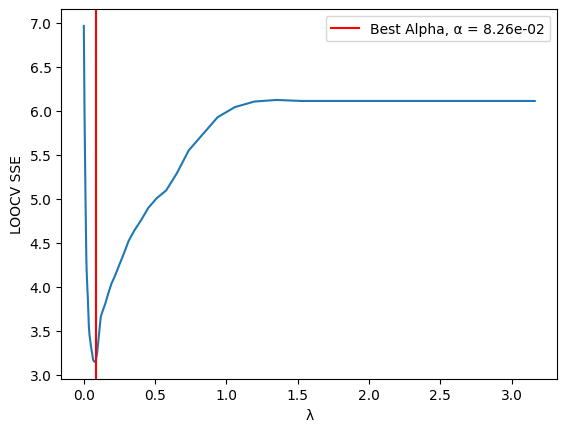

Best alpha:  0.08262004499074288
Best SSE:  3.149064623497577


In [15]:
n_alphas = 200
alphas = np.logspace(-10, 0.5, n_alphas)
ssearray = []
for i in alphas:
    alphasse = loocvlasso(xtrain,ytrain,i)
    ssearray.append(alphasse)

bestalpha = alphas[np.argmin(np.array(ssearray))]
plt.figure()
plt.plot(alphas,ssearray)
plt.xlabel("\u03bb")
plt.ylabel("LOOCV SSE")
plt.axvline(x = bestalpha, color = 'r', label = 'Best Alpha, \u03B1 = {:.2e}'.format(bestalpha))
plt.legend()
plt.show()
bestalphaindex = np.argmin(np.array(ssearray))
bestsse = np.min(np.array(ssearray))
print("Best alpha: ", alphas[np.argmin(np.array(ssearray))])
print("Best SSE: ", np.min(np.array(ssearray)))

Same best alpha as before

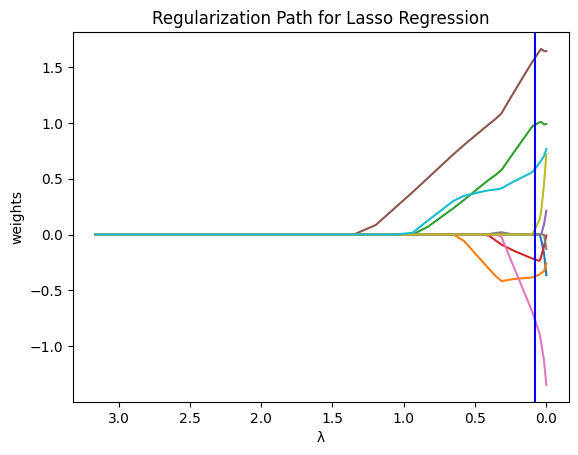

Lasso coefficients: [-0.         -0.37662907  0.98059535 -0.2218726   0.          1.57751788
 -0.75383293  0.          0.04186607  0.58389155]


In [16]:
coeeflist = []
for i in alphas:
    model = Lasso(i)
    model.fit(xtrain,ytrain)
    coeeflist.append(model.coef_)
plt.figure()
plt.plot(alphas,coeeflist)
#plt.xlim(0,6)
plt.gca().invert_xaxis()
plt.xlabel('\u03bb')
plt.title("Regularization Path for Lasso Regression")
plt.ylabel('weights')
plt.axvline(x = bestalpha, color = 'b', label = 'axvline - full height')
plt.show()
print("Lasso coefficients:",coeeflist[bestalphaindex])

Some weights are at 0, which is consistent with what we've seen from the variables correlation

In [17]:

clf = Lasso(alpha=0.08262004499074288)
clf.fit(xtrain,ytrain)
#clf.coef_

# calculate pred value

pred = clf.predict(xtrain)
format_ypred = pred.reshape(pred.shape[0],1)

# using the cross_val_score function we obtain the same results as in the first method, yet, 
# we chose to try the functions we implemented for testing purposes. in the report, the statistics used
# are the ones from the first method

#scores = cross_val_score(clf, xtrain, ytrain, cv=LeaveOneOut(), scoring='neg_mean_squared_error')
#print(np.mean(scores))

# evaluate model
evlasso1 = evaluate_sse(ytrain,format_ypred)
r2_lasso = r2_score(ytrain,format_ypred)
print("Lasso Train SSE:", evlasso1)
print("Lasso Train R2:", r2_lasso , "\n")

#loocv with best alpha
validation_sse = loocvlasso(xtrain,ytrain,bestalpha)
print("Lasso LOOCV Validation SSE:", validation_sse)

# kfold with best alpha
kfold_sse = kfold_lasso(xtrain,ytrain,bestalpha,3)
print("Lasso 5-fold Validation SSE:", kfold_sse[0])
print("Lasso 5-fold Validation R2:", kfold_sse[1])



Lasso Train SSE: 6.507257279172986
Lasso Train R2: 0.9077904946992317 

Lasso LOOCV Validation SSE: [3.14906462]
Lasso 5-fold Validation SSE: 6.651741726473511
Lasso 5-fold Validation R2: -1.4459693550211534


In [34]:
# perform feature selection on the original data to remove feature with coef 0 in lasso

index = np.where(coeeflist[bestalphaindex] == 0)
print(index)


xtrain_new = np.delete(xtrain, index, axis = 1)
xtest_new = np.delete(xtest, index, axis = 1)

# linear regression with the new data

mod_lin = LinearRegression(fit_intercept=True)
mod_lin.fit(xtrain_new, ytrain)

# calculate score

scores = cross_val_score(mod_lin, xtrain_new, ytrain, cv=LeaveOneOut(), scoring='neg_mean_squared_error')

print("LOOCV MSE: ", np.mean(-scores))



(array([0, 4, 7], dtype=int64),)
LOOCV MSE:  2.8462715317651677


### Regression using normal equations

In [18]:
#build X matrix
X = np.insert(xtrain,0,np.ones(xtrain.shape[0]),axis=1)

In [19]:
# building a linear regression model using the normal equations

def normal_reg(x,y):
   X = np.insert(x,0,np.ones(x.shape[0]),axis=1)
   M1 = np.linalg.inv(np.matmul(X.transpose(),X))
   M2 = np.matmul(M1, X.transpose())
   beta = np.matmul(M2,y)
   return beta


In [20]:
# get beta values

mod_normal = normal_reg(xtrain,ytrain)

In [21]:
# calculate pred value
evnormal = evaluate_sse(ytrain,np.matmul(X,mod_normal))
print("Train SSE:", evnormal)
r2_normal = r2_score(ytrain,np.matmul(X,mod_normal))
print("Train R2:", r2_normal)

Train SSE: 4.936506866464357
Train R2: 0.9300484310759609


In [22]:
model_reg = LinearRegression(fit_intercept=True) #data is not centralized
model_reg.coef_ = mod_normal

# cross val to get mse

scores = cross_val_score(model_reg, xtrain, ytrain, cv=LeaveOneOut(), scoring='neg_mean_squared_error')
print("LOOCV MSE: ", np.mean(-scores))

# cross val k fold 3 to get mse

scores = cross_val_score(model_reg, xtrain, ytrain, cv=3, scoring='neg_mean_squared_error')
print("CV k=3 MSE: ", np.mean(-scores))

# cross val k fold 3 to get r2

scores = cross_val_score(model_reg, xtrain, ytrain, cv=3, scoring='r2')
print("CV k=3 r2: ", np.mean(-scores))



LOOCV MSE:  7.864171987128417
CV k=3 MSE:  18.92285866105715
CV k=3 r2:  8.465229245898724


### Ridge

Using GridSearchCV and other packages

In [24]:
# ridge

n_alphas = 200
alphas = np.logspace(-10, 1, n_alphas)

param_grid = {"alpha": alphas}
modelridge = Ridge(fit_intercept=True)

search = GridSearchCV(estimator=modelridge, param_grid=param_grid, n_jobs=2, scoring='neg_mean_squared_error', cv=LeaveOneOut())
search.fit(xtrain, ytrain)

print(f"The best parameters found are: {search.best_params_}")

best_alpharidge = search.best_params_['alpha']


The best parameters found are: {'alpha': 2.4658110758226037}


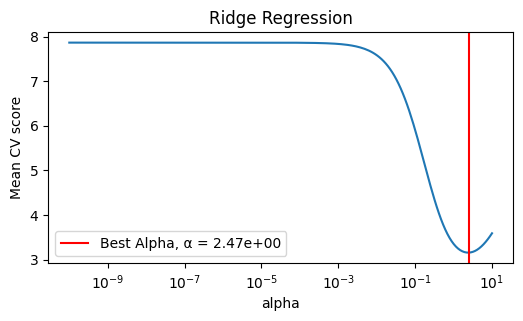

In [25]:
search.cv_results_.keys()

# get test scores for each splits

test_scores = np.zeros((len(search.cv_results_['params']), search.n_splits_))
for i, params in enumerate(search.cv_results_['params']):
    for j in range(search.n_splits_):
        test_scores[i, j] = search.cv_results_[f'split{j}_test_score'][i]

# plot test scores

plt.figure(figsize=(6, 3))
plt.semilogx(alphas, -test_scores.mean(axis=1))
plt.xlabel('alpha')
plt.axvline(x = best_alpharidge, color = 'r', label = 'Best Alpha, \u03B1 = {:.2e}'.format(best_alpharidge))
plt.legend()
plt.ylabel('Mean CV score')
plt.title('Ridge Regression')
plt.show()

In [26]:
print("Ridge Statistics\n")

print(f"The mean CV score of the model with the best alpha (using LOOCV) is: {-search.best_score_:.3f}")

mseridge = cross_val_score(search.best_estimator_, xtrain, ytrain, cv=11, scoring='neg_mean_squared_error')
print(f"The MSE score of the model using the best alpha with CV k=11 is: {np.mean(-mseridge):.3f}")


# get r2

scores = cross_val_score(search.best_estimator_, xtrain, ytrain, cv=5, scoring='r2')
print(f"The mean r2 (test) score of the best model is: {scores.mean():.3f}")

# predict

ypred = search.best_estimator_.predict(xtrain)

# get train r2

r2 = r2_score(ytrain, ypred)
print(f"The r2 (train) score of the best model is: {r2:.3f}")

Ridge Statistics

The mean CV score of the model with the best alpha (using LOOCV) is: 3.154
The MSE score of the model using the best alpha with CV k=11 is: 3.833
The mean r2 (test) score of the best model is: -1.403
The r2 (train) score of the best model is: 0.889


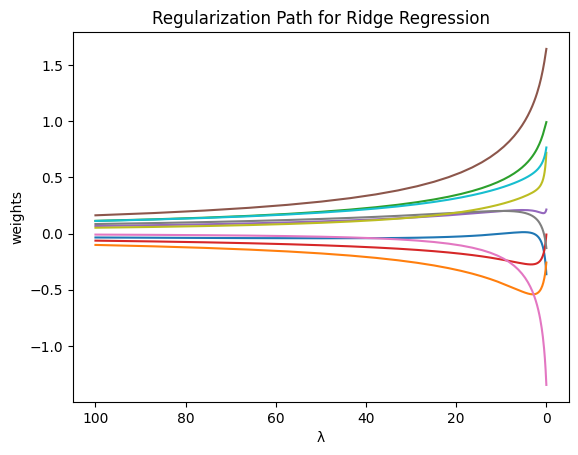

In [27]:
# using regularization path, weights vs lambda 

def ridge_reg(x,y,alpha):
    ridge = Ridge(alpha=alpha)
    ridge.fit(x,y)
    return ridge.coef_

def ridge_reg_path(x,y,alphas):
    weights = []
    for alpha in alphas:
        weights.append(ridge_reg(x,y,alpha)[0])
    return np.array(weights)

n_alphas = 200
alphas = np.logspace(-10, 2, n_alphas)
weights = ridge_reg_path(xtrain,ytrain,alphas)

for i in range(len(weights[0])):
    plt.plot(alphas,weights[:,i])
plt.xlabel('\u03bb')
plt.gca().invert_xaxis()
plt.title("Regularization Path for Ridge Regression")
plt.ylabel('weights')
plt.show()

### Elastic Net regularization

In [28]:
# ELASTIC NET

from sklearn.linear_model import ElasticNet

n_alphas = 200
alphas = np.logspace(-10, 1, n_alphas)

param_grid = {"alpha": alphas}
model_to_tune = ElasticNet()

searchelastic = GridSearchCV(estimator=model_to_tune, param_grid=param_grid, n_jobs=2, scoring='neg_mean_squared_error', cv=LeaveOneOut())
searchelastic.fit(xtrain, ytrain)

print(f"The best parameters found are: {searchelastic.best_params_}")

best_alphaelastic = searchelastic.best_params_['alpha']

The best parameters found are: {'alpha': 0.11623224686798542}


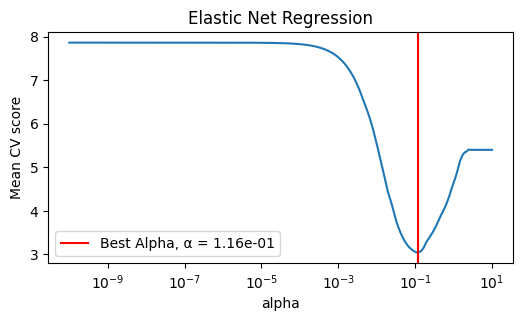

In [29]:
searchelastic.cv_results_.keys()

# get test scores for each splits

test_scoreselastic = np.zeros((len(searchelastic.cv_results_['params']), searchelastic.n_splits_))
for i, params in enumerate(searchelastic.cv_results_['params']):
    for j in range(searchelastic.n_splits_):
        test_scoreselastic[i, j] = searchelastic.cv_results_[f'split{j}_test_score'][i]

# plot test scores

plt.figure(figsize=(6, 3))
plt.semilogx(alphas, -test_scoreselastic.mean(axis=1))

plt.xlabel('alpha')
plt.ylabel('Mean CV score')
plt.axvline(x = best_alphaelastic, color = 'r', label = 'Best Alpha, \u03B1 = {:.2e}'.format(best_alphaelastic))
plt.legend()
plt.title('Elastic Net Regression')
plt.show()

In [30]:

print(f"The mean CV score of the model with the best alpha is: {-searchelastic.best_score_:.3f}")

mse = cross_val_score(searchelastic.best_estimator_, xtrain, ytrain, cv=11, scoring='neg_mean_squared_error')
print(f"The MSE score of the model using the best alpha with CV k=11 is: {np.mean(-mse):.3f}")


# get r2

scoreselastic = cross_val_score(searchelastic.best_estimator_, xtrain, ytrain, cv=3, scoring='r2')
print(f"The mean r2 (test) score of the best model is: {scoreselastic.mean():.3f}")

# predict

ypred = searchelastic.best_estimator_.predict(xtrain)

# get train r2

r2 = r2_score(ytrain, ypred)
print(f"The r2 (train) score of the best model is: {r2:.3f}")

The mean CV score of the model with the best alpha is: 3.041
The MSE score of the model using the best alpha with CV k=11 is: 3.876
The mean r2 (test) score of the best model is: -1.586
The r2 (train) score of the best model is: 0.900
